In [145]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from itertools import product
%matplotlib inline

In [146]:
fire_data = pd.read_csv('dataset/amazon.csv',encoding='latin1')
# check if there is invalid data value in the dataframe
fire_data.isnull().sum()

year      0
state     0
month     0
number    0
date      0
dtype: int64

In [147]:
gb=fire_data.groupby('state')
states_df = [gb.get_group(x) for x in gb.groups]
# Pick one state to do the forecasting
target_df= states_df[2]
target_df.head()

,year,state,month,number,date
479,1998,Amapa,Janeiro,0.0,1998-01-01
480,1999,Amapa,Janeiro,0.0,1999-01-01
481,2000,Amapa,Janeiro,2.0,2000-01-01
482,2001,Amapa,Janeiro,0.0,2001-01-01
483,2002,Amapa,Janeiro,7.0,2002-01-01


In [148]:
# Create the month mapping from latin to numbers
month_keys = set(target_df['month'])
# print(month_keys)
month_dict={
    'Março': 3, 
    'Junho': 6, 
    'Abril': 4, 
    'Setembro': 9,
    'Fevereiro': 2, 
    'Agosto': 8,
    'Maio': 5,
    'Novembro': 11,
    'Janeiro':1, 
    'Julho': 7,
    'Dezembro': 12,
    'Outubro':10
}
# convert month to sortabke numerical values
target_df['month'] = target_df['month'].apply(lambda x: month_dict[x])
target_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,year,state,month,number,date
479,1998,Amapa,1,0.0,1998-01-01
480,1999,Amapa,1,0.0,1999-01-01
481,2000,Amapa,1,2.0,2000-01-01
482,2001,Amapa,1,0.0,2001-01-01
483,2002,Amapa,1,7.0,2002-01-01


In [149]:
# Prepare the dataset
target_df['day']=1
target_df.index=pd.DatetimeIndex(pd.to_datetime(target_df[['year', 'month','day']]))
target_df.sort_index(inplace=True,ascending=True)
target_df = target_df.loc[:, ['number']] # drop all irrelavant columns
target_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,number
1998-01-01,0.0
1998-02-01,0.0
1998-03-01,0.0
1998-04-01,0.0
1998-05-01,0.0


In [150]:
# Now split the data into input sequences to generate acceptable input dataset for the network
# Plan to try vanilla LSTM first
def split_data(ts, input_len, output_len):
    inputs=[]
    outputs=[]
    for i in range(len(ts)):
        if i+input_len+output_len<len(ts):
            sample=ts[i:i+input_len]
            gt=ts[i+input_len:i+input_len+output_len]
            inputs.append(sample)
            outputs.append(gt)
    return np.array(inputs), np.array(outputs)

In [151]:
input_len=12
output_len=1
inputs, outputs=split_data(target_df.number, input_len, output_len)
assert len(inputs)==len(outputs)
inputs = inputs.reshape((inputs.shape[0], inputs.shape[1], n_features)) # add third dimension to the inputs

In [152]:
dataset_size=len(inputs)
print(dataset_size)
print(len(target_df.number))

226
239


In [153]:
# split a univariate dataset into train/test sets
def train_test_split(X, y, r):
    index=int(X.shape[0]*r)
    return (X[:index], y[:index]),(X[index:], y[index:])

In [154]:
r=0.8
(train_X, train_y),(test_X, test_y) = train_test_split(inputs, outputs, r)
print(len(train_X))

180


## Vanilla LSTM

In [155]:
# Now build the model
import tensorflow as tf

In [156]:
# define model
n_features=1
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(input_len, n_features)))
model.add(tf.keras.layers.Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 50)                10400     
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [157]:
def plot_loss_history(history):
    # Get training and test loss histories
    training_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(training_loss) + 1)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

In [158]:
history=model.fit(train_X, train_y, epochs=10, validation_split=0.1,verbose=1) # now try validation split without shuffling training data

Train on 162 samples, validate on 18 samples
Epoch 1/10
162/162 [==============================] - 1s 7ms/sample - loss: 34209.0431 - val_loss: 86164.5312
Epoch 2/10
162/162 [==============================] - 0s 377us/sample - loss: 32962.5583 - val_loss: 78728.7812
Epoch 3/10
162/162 [==============================] - 0s 343us/sample - loss: 30497.5287 - val_loss: 71882.1641
Epoch 4/10
162/162 [==============================] - 0s 377us/sample - loss: 27671.3859 - val_loss: 70340.1641
Epoch 5/10
162/162 [==============================] - 0s 389us/sample - loss: 26229.3398 - val_loss: 63851.9922
Epoch 6/10
162/162 [==============================] - 0s 361us/sample - loss: 23731.4553 - val_loss: 61582.1719
Epoch 7/10
162/162 [==============================] - 0s 313us/sample - loss: 22056.9096 - val_loss: 53383.1172
Epoch 8/10
162/162 [==============================] - 0s 303us/sample - loss: 21745.4301 - val_loss: 49851.7617
Epoch 9/10
162/162 [==============================] - 0s 329u

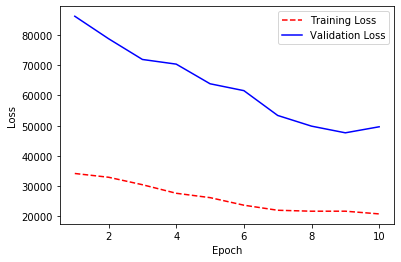

In [159]:
plot_loss_history(history)

Looks like the vanilla LSTM model is both high bias and high variance. Let's train longer see if it helps.

In [163]:
history=model.fit(train_X, train_y, epochs=50, validation_split=0.1,verbose=1) # now try validation split without shuffling training data

Train on 162 samples, validate on 18 samples
Epoch 1/50
162/162 [==============================] - 0s 452us/sample - loss: 15326.1447 - val_loss: 51651.9492
Epoch 2/50
162/162 [==============================] - 0s 390us/sample - loss: 17675.4779 - val_loss: 52939.4023
Epoch 3/50
162/162 [==============================] - 0s 388us/sample - loss: 18661.0044 - val_loss: 53530.3047
Epoch 4/50
162/162 [==============================] - 0s 388us/sample - loss: 18435.4755 - val_loss: 59132.6523
Epoch 5/50
162/162 [==============================] - 0s 409us/sample - loss: 18531.3553 - val_loss: 55863.1328
Epoch 6/50
162/162 [==============================] - 0s 436us/sample - loss: 16991.5818 - val_loss: 55122.6719
Epoch 7/50
162/162 [==============================] - 0s 412us/sample - loss: 16155.4327 - val_loss: 53711.3906
Epoch 8/50
162/162 [==============================] - 0s 415us/sample - loss: 15287.6462 - val_loss: 52122.4414
Epoch 9/50
162/162 [==============================] - 0s 44

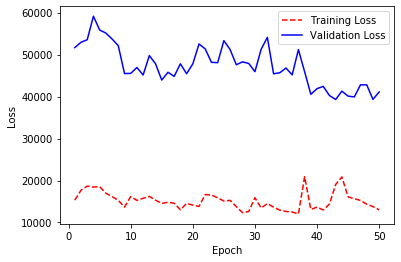

In [164]:
plot_loss_history(history)

Training longer does not help in this case. Both trainig and validation errors fluctuate alot. The model is under powered for this task.

In [ ]:
## predictions = model.predict(test_X)
# print(predictions)
plt.plot(predictions,'r-')
plt.plot(test_y,'g-')

## Bidirectional LSTM

In [171]:
from tensorflow.keras.layers import Bidirectional, LSTM, Dense
model_bilstm = tf.keras.Sequential()
model_bilstm.add(Bidirectional(LSTM(50, activation='relu', input_shape=(input_len, n_features))))
model_bilstm.add(Dense(1))
model_bilstm.compile(optimizer='adam', loss='mse')
# model_bilstm.summary()
bilstm_history=model_bilstm.fit(
                                train_X, 
                                train_y, 
                                epochs=20, 
                                validation_split=0.1,
#                                 shuffle=True,
                                verbose=1
                            ) # now try validation split with shuffling training data

Train on 162 samples, validate on 18 samples
Epoch 1/20
162/162 [==============================] - 2s 13ms/sample - loss: 37329.2686 - val_loss: 93701.8750
Epoch 2/20
162/162 [==============================] - 0s 494us/sample - loss: 34757.9575 - val_loss: 86501.4297
Epoch 3/20
162/162 [==============================] - 0s 473us/sample - loss: 31457.4715 - val_loss: 73668.5312
Epoch 4/20
162/162 [==============================] - 0s 513us/sample - loss: 26390.7394 - val_loss: 53366.8906
Epoch 5/20
162/162 [==============================] - 0s 514us/sample - loss: 22368.0064 - val_loss: 46456.7383
Epoch 6/20
162/162 [==============================] - 0s 446us/sample - loss: 18353.7533 - val_loss: 40478.4688
Epoch 7/20
162/162 [==============================] - 0s 454us/sample - loss: 16690.4733 - val_loss: 43088.8867
Epoch 8/20
162/162 [==============================] - 0s 510us/sample - loss: 14948.8699 - val_loss: 42531.3867
Epoch 9/20
162/162 [==============================] - 0s 563

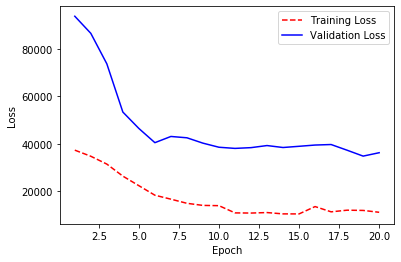

In [172]:
plot_loss_history(bilstm_history)

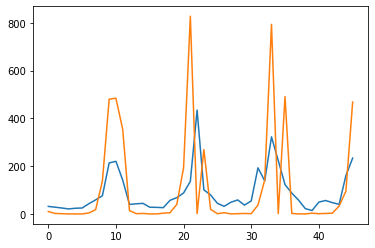

In [108]:
predictions = model_bilstm.predict(test_X)
# print(predictions)
plt.plot(predictions)
plt.plot(test_y)

## Stacked LSTM

In [62]:
model_slstm = tf.keras.Sequential()
model_slstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(input_len, n_features)))
model_slstm.add(LSTM(50, activation='relu'))
model_slstm.add(Dense(1))
model_slstm.compile(optimizer='adam', loss='mse')
model_slstm.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 12, 50)            10400     
_________________________________________________________________
lstm_10 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [182]:
history_slstm=model_slstm.fit(train_X, train_y, epochs=20, validation_split=0.1, verbose=1) # now try validation split without shuffling training data

Train on 162 samples, validate on 18 samples
Epoch 1/20
162/162 [==============================] - 0s 722us/sample - loss: 2400.5639 - val_loss: 64487.5078
Epoch 2/20
162/162 [==============================] - 0s 634us/sample - loss: 2344.3452 - val_loss: 63613.6523
Epoch 3/20
162/162 [==============================] - 0s 614us/sample - loss: 2283.5521 - val_loss: 64634.9297
Epoch 4/20
162/162 [==============================] - 0s 567us/sample - loss: 2213.9733 - val_loss: 71302.5000
Epoch 5/20
162/162 [==============================] - 0s 697us/sample - loss: 2162.0368 - val_loss: 70328.2812
Epoch 6/20
162/162 [==============================] - 0s 675us/sample - loss: 2544.9929 - val_loss: 66766.4688
Epoch 7/20
162/162 [==============================] - 0s 596us/sample - loss: 2304.8747 - val_loss: 67220.2500
Epoch 8/20
162/162 [==============================] - 0s 651us/sample - loss: 2256.8894 - val_loss: 70023.4219
Epoch 9/20
162/162 [==============================] - 0s 592us/samp

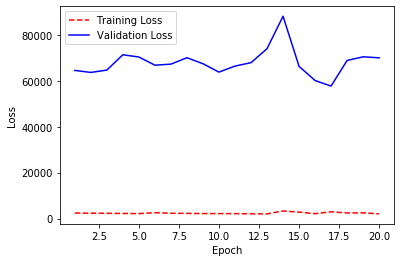

In [183]:
plot_loss_history(history_slstm)

### Stack Bidirectional LSTM

In [186]:
model_sbilstm = tf.keras.Sequential()
model_sbilstm.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True, input_shape=(input_len, n_features))))
model_sbilstm.add(Bidirectional(LSTM(50, activation='relu')))
model_sbilstm.add(Dense(1))
model_sbilstm.compile(optimizer='adam', loss='mse')
# model_bilstm.summary()
sbilstm_history=model_bilstm.fit(
                                train_X, 
                                train_y, 
                                epochs=100, 
                                validation_split=0.1,
#                                 shuffle=True,
                                verbose=1
                            ) # now try validation split with shuffling training data

Train on 162 samples, validate on 18 samples
Epoch 1/100
162/162 [==============================] - 0s 569us/sample - loss: 3317.7384 - val_loss: 47787.0625
Epoch 2/100
162/162 [==============================] - 0s 565us/sample - loss: 3375.4910 - val_loss: 48538.6406
Epoch 3/100
162/162 [==============================] - 0s 516us/sample - loss: 3165.9146 - val_loss: 48931.8203
Epoch 4/100
162/162 [==============================] - 0s 499us/sample - loss: 3090.0177 - val_loss: 49911.7578
Epoch 5/100
162/162 [==============================] - 0s 633us/sample - loss: 3949.9248 - val_loss: 46867.3672
Epoch 6/100
162/162 [==============================] - 0s 757us/sample - loss: 4318.7268 - val_loss: 45774.8242
Epoch 7/100
162/162 [==============================] - 0s 661us/sample - loss: 4153.6263 - val_loss: 46032.9375
Epoch 8/100
162/162 [==============================] - 0s 521us/sample - loss: 3975.1112 - val_loss: 46952.7695
Epoch 9/100
162/162 [==============================] - 0s 5

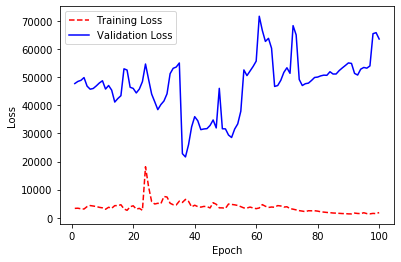

In [187]:
plot_loss_history(sbilstm_history)

### Conclusion:
All the NN modesl do not seem to work very well for this dataset maybe because it is too small.
We run into general overfitting problems because we do not have enough data.